# Initialize

## Import Dependencies

In [1]:
# external dependencies
from snippets.deps import *

# utils 
from snippets.filters import *

## Path Macros

In [2]:
proj_dir = pathlib.Path().resolve()
data_dir = os.path.join(proj_dir, "data")
config_dir = os.path.join(proj_dir, "config")

# Configuration Arguments

In [7]:
config_path = os.path.join(config_dir, "main.toml")
config = None
with open(config_path, "rb") as f:
    config = tomllib.load(f)

data_config = config["main"]["data"]
analytics_config = config["main"]["analytics"]
model_config = config["main"]["model"]

## Load Pre-trained Models and Tokenizers

In [12]:
def load_models(model_name, glb_config): 
    torch.set_default_device("cpu")
    model = None
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name, 
    #     torch_dtype = "auto", 
    #     trust_remote_code = True)
    # model = model.eval()
    tokenizer = AutoTokenizer.from_pretrained(
        model_name, 
        trust_remote_code = True)
    return (model, tokenizer)

model_gpt3, tokenizer_gpt3 = load_models("Xenova/gpt-3.5-turbo", None)
model_gpt4, tokenizer_gpt4 = load_models("Xenova/gpt-4o", None) 
models = {
    "gpt3-5": model_gpt3, 
    "gpt4": model_gpt4
}
tokenizers = {
    "gpt3-5": tokenizer_gpt3, 
    "gpt4": tokenizer_gpt4
}

# Gather Raw Data

In [13]:
df_raw = pd.read_pickle(os.path.join(data_dir, "latest_dataset_unquantized.pkl"))
# df_raw.loc[:, 'message'] = df_raw['message'].apply(
#     lambda x: emoji.demojize(x))
# df_raw.loc[:, 'response'] = df_raw['response'].apply(
#     lambda x: emoji.demojize(x))
    
df_gpt3 = df_raw[df_raw['model'].str.contains('gpt3-5')]
if analytics_config["save-intermediate-data"]:
    df_gpt3.to_csv(os.path.join(data_dir, "gpt3-5.csv"))
# df_gpt4 = df_raw[df_raw['model'].str.contains('gpt-4o')]
# df_gpt4.to_csv(os.path.join(data_dir, "gpt-4o.csv"))
    
dataframes = [df_gpt3]
    
# for df_index, df in enumerate(dataframes): 
#     # Delete non-standard characters 
#     df.loc[:, 'message'] = df['message'].apply(
#         lambda x: x if filters.is_standard_english(x) else None)
#     df.loc[:, 'response'] = df['response'].apply(
#         lambda x: x if filters.is_standard_english(x) else None)
#     df = df.dropna(subset=['message', 'response'])
#     dataframes[df_index] = df



# Populate Pre-processed Data

In [14]:
for df_index, df in enumerate(dataframes): 
        df = df.copy()
        df.loc[:, 'message_tokens'] = None
        df.loc[:, 'response_tokens'] = None
        df.loc[:, 'latency'] = None
        dataframes[df_index] = df
        # for each row, tokenize the message and response columns
        for row_index, row in df.iterrows():
            model_name = df['model'].iloc[0]
            
            message = row['message']
            response = row['response']
            start_time = float(row['start_timestamp'])
            end_time = float(row['end_timestamp'])
            latency = end_time - start_time
            message_tokens = tokenizers[model_name].tokenize(message)
            response_tokens = tokenizers[model_name].tokenize(response)
            df.at[row_index, 'message_tokens'] = len(message_tokens)
            df.at[row_index, 'response_tokens'] = len(response_tokens)
            df.at[row_index, 'latency'] = latency

# Filter out data points with XXXL latency
for df_index, df in enumerate(dataframes):
    dataframes[df_index] = df[df['latency'] < 20]

# Save data
if analytics_config["save-intermediate-data"]:
    dataframes[0].to_csv(os.path.join(data_dir, "latest_dataset_gpt3.csv"), index=False, encoding='utf-8')  # index=False to exclude row numbers 
    # dataframes[1].to_csv(os.path.join(data_dir, "latest_dataset_gpt4.csv"), index=False, encoding='utf-8')  # index=False to exclude row numbers 

Token indices sequence length is longer than the specified maximum sequence length for this model (8411 > 4096). Running this sequence through the model will result in indexing errors


# Scatter plots of pre-processed Data

In [15]:
sns.set_theme(style="whitegrid")

## Input scatter

<Figure size 640x480 with 0 Axes>

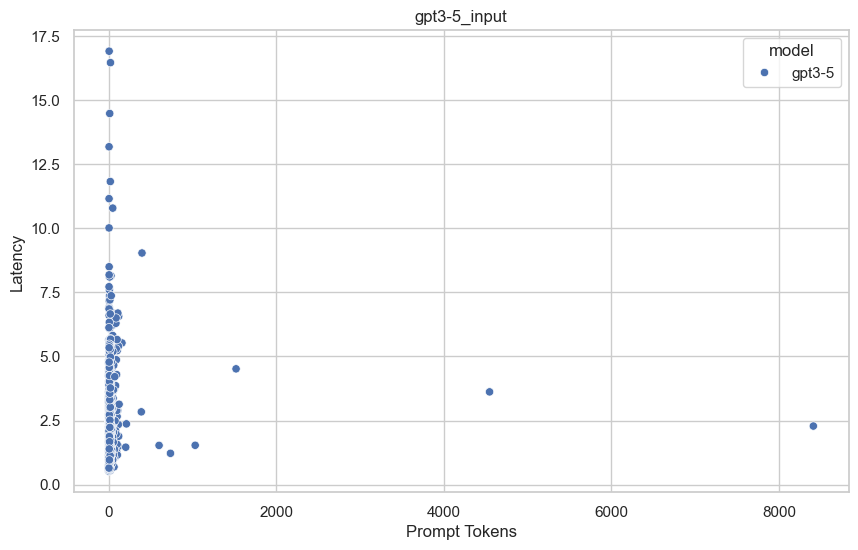

<Figure size 640x480 with 0 Axes>

In [16]:
for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]
    
    # input scatter
    plt.clf()
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='message_tokens', y='latency', hue='model')
    plt.xlabel('Prompt Tokens')
    plt.ylabel('Latency')
    plt.title(model_name + '_input')
    plt.show()
    plt.savefig('data/scatter_' + model_name + '_input' + '.png') 
    


## Output scatter

<Figure size 640x480 with 0 Axes>

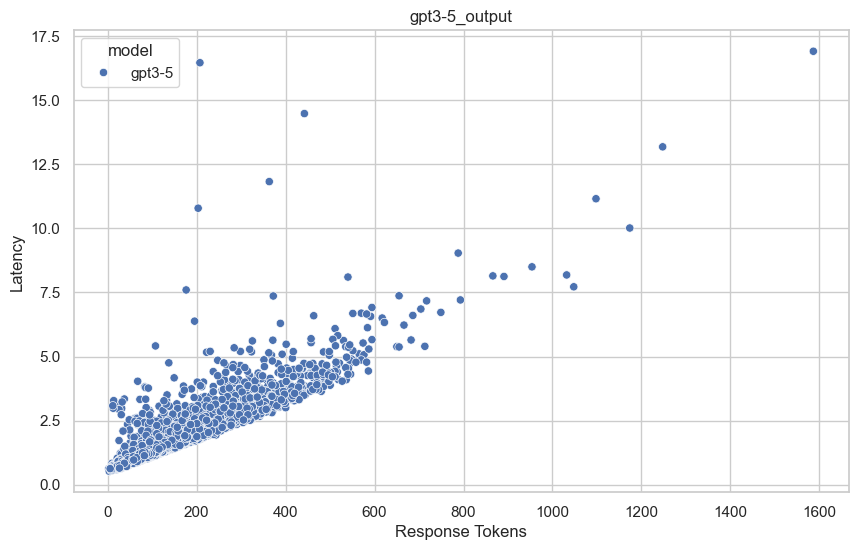

<Figure size 640x480 with 0 Axes>

In [17]:
for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]
    
    # output scatter 
    plt.clf()
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='response_tokens', y='latency', hue='model')
    plt.xlabel('Response Tokens')
    plt.ylabel('Latency')
    plt.title(model_name + '_output')
    plt.show()
    plt.savefig('data/scatter_' + model_name + '_output' + '.png')

## Input CDF 

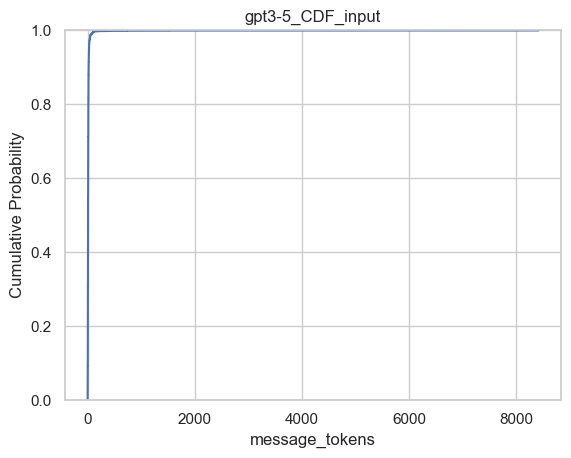

<Figure size 640x480 with 0 Axes>

In [18]:
for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]    
    
    # input cdf 
    plt.clf() 
    sns.ecdfplot(data=df['message_tokens'])
    plt.xlabel('message_tokens')
    plt.ylabel('Cumulative Probability')
    plt.title(model_name +'_CDF' +  '_input')
    plt.show()
    plt.savefig('data/cdf_' + model_name + '_input' + '.png')

## Output CDF 

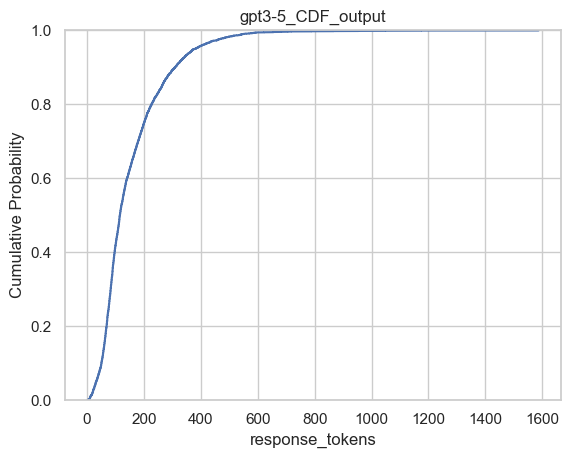

<Figure size 640x480 with 0 Axes>

In [19]:
for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]    
    
    # output cdf 
    plt.clf() 
    sns.ecdfplot(data=df['response_tokens'])
    plt.xlabel('response_tokens')
    plt.ylabel('Cumulative Probability')
    plt.title(model_name +'_CDF' +  '_output')
    plt.show()
    plt.savefig('data/cdf_' + model_name + '_output' + '.png')

## Latency CDF

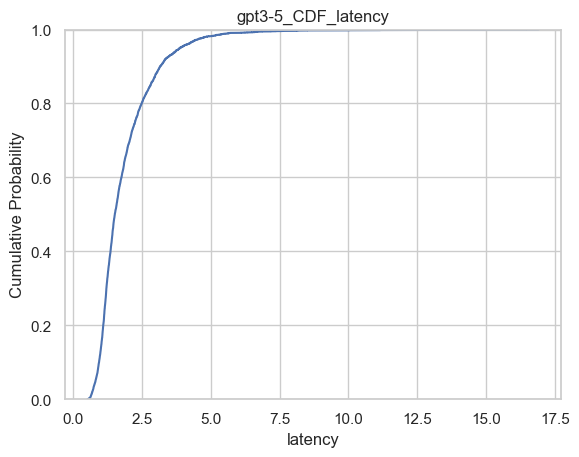

<Figure size 640x480 with 0 Axes>

In [20]:
for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]
    
    # latency cdf 
    plt.clf() 
    sns.ecdfplot(data=df['latency'])
    plt.xlabel('latency')
    plt.ylabel('Cumulative Probability')
    plt.title(model_name +'_CDF' +  '_latency')
    plt.show()
    plt.savefig('data/cdf_' + model_name + '_latency' + '.png')

# Filter by TPS 

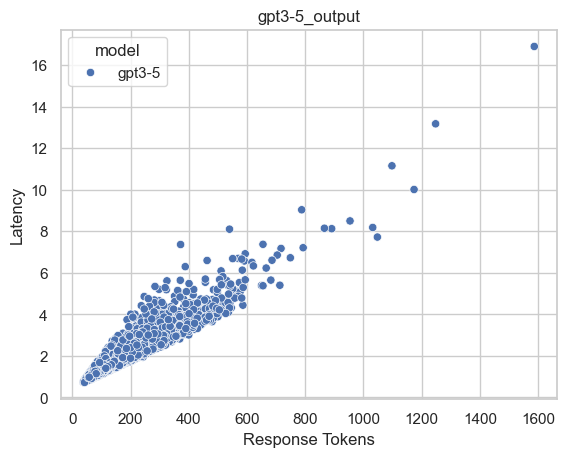

In [21]:
# TPS envelope
tps_upper = float('inf')
tps_lower = 50 

for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]
    df['tps'] = df['response_tokens'] / df['latency']
    
    # draw tps cdf plot 
    plt.clf()
    sns.ecdfplot(data=df['tps'])
    plt.xlabel('tps')
    plt.ylabel('Cumulative Probability')
    plt.title(model_name +'_CDF' +  '_tps')
    plt.savefig('data/cdf_' + model_name + '_tps' + '.png') 
    
    # filter out tps
    df = df[(df['tps'] > tps_lower) & (df['tps'] < tps_upper)]
    
    dataframes[df_index] = df

## tps affecting factors 

# for each data frame
for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]
    
    # tps vs output tokens 
    plt.clf()
    sns.scatterplot(data=df, x='response_tokens', y='tps', hue='model')
    plt.xlabel('Response Tokens')
    plt.ylabel('TPS')
    plt.title(model_name + '_output')
    plt.savefig('data/scatter_' + model_name + '_tps_output_qremaining' + '.png') 

    # latency vs output tokens 
    plt.clf()
    sns.scatterplot(data=df, x='response_tokens', y='latency', hue='model')
    plt.xlabel('Response Tokens')
    plt.ylabel('Latency')
    plt.title(model_name + '_output')
    plt.savefig('data/scatter_' + model_name + '_latency_output_qremaining' + '.png')

# Pair-wise Analysis

In [28]:
# Define tolerances and threshold
column1_tolerance = 5
column2_tolerance = 5
column3_threshold = 0

column_name3 = 'latency'
column_name1 = 'message_tokens'
column_name2 = 'response_tokens'

PAIR_WISE_REGEN = False
if PAIR_WISE_REGEN: 
    for df_index, df in enumerate(dataframes): 
        model_name = df['model'].iloc[0]
        exp_name = column_name3 + '_diff_' + model_name
        exp_folder = os.path.join(data_dir, exp_name)
        
        indices = df.index.tolist()
        incl_pairs = []
        excl_pairs = []
                
        for idx1, idx2 in tqdm.tqdm(combinations(indices, 2), total=len(indices)*(len(indices)-1)//2):
            # Extract the rows as series
            row1 = df.loc[idx1]
            row2 = df.loc[idx2]
    
            # Check if column1 and column2 values are within tolerances
            if (abs(row1[column_name1] - row2[column_name1]) <= column1_tolerance) and (abs(row1[column_name2] - row2[column_name2]) <= column2_tolerance):
                # Check if column3 difference is greater than threshold
                diff = abs(row1[column_name3] - row2[column_name3])
                if diff >= column3_threshold:
                # Store the pair with original data
                    incl_pairs.append({
                        'Row1_Index': idx1,
                        'Row2_Index': idx2,
                        column_name1 + '1': row1[column_name1],
                        column_name1 + '2': row2[column_name1],
                        column_name2 + '1': row1[column_name2],
                        column_name2 + '2': row2[column_name2],
                        column_name3 + '1': row1[column_name3],
                        column_name3 + '2': row2[column_name3],
                        column_name3 + '_Difference': diff
                    }) 
                else: 
                    excl_pairs.append({
                        'Row1_Index': idx1,
                        'Row2_Index': idx2, 
                        column_name1 + '1': row1[column_name1],
                        column_name1 + '2': row2[column_name1],
                        column_name2 + '1': row1[column_name2],
                        column_name2 + '2': row2[column_name2],
                        column_name3 + '1': row1[column_name3],
                        column_name3 + '2': row2[column_name3],
                        column_name3 + '_Difference': diff
                    })
        incl_pairs_df = pd.DataFrame(incl_pairs) 
        excl_pairs_df = pd.DataFrame(excl_pairs)

        path = os.path.join(exp_folder, 'incl_pairs_' + model_name + '.csv')
        incl_pairs_df.to_csv(path, index=False)

        path = os.path.join(exp_folder, 'excl_pairs_' + model_name + '.csv')
        excl_pairs_df.to_csv(path, index=False)

In [1]:
# Pull difference data
for df_index, df in enumerate(dataframes): 
    model_name = df['model'].iloc[0]
    exp_name = column_name3 + '_diff_' + model_name
    exp_folder = os.path.join(data_dir, exp_name)
    
    indices = df.index.tolist()
    
    incl_pairs_df = pd.read_csv(os.path.join(exp_folder, 'incl_pairs_' + model_name + '.csv'))
    row_index1 = incl_pairs_df['Row1_Index'].tolist()
    row_index2 = incl_pairs_df['Row2_Index'].tolist() 
    
    incl_result_dataframe = pd.DataFrame(columns = [
        'model',
        column_name3 + '1',
        column_name3 + '2',
        column_name3 + '_Difference',
        column_name1 + '1',
        column_name1 + '2',
        column_name2 + '1',
        column_name2 + '2',
        'message1',
        'message2',
        'response1',
        'response2'
    ])
    for curr_idx1, curr_idx2 in zip(row_index1, row_index2):
        row1 = df.loc[curr_idx1]
        row2 = df.loc[curr_idx2]
        # add one row to new dataframe
        incl_result_dataframe = incl_result_dataframe._append({
            'model': row1['model'],
            column_name3 + '1': row1[column_name3],
            column_name3 + '2': row2[column_name3],
            column_name3 + '_Difference': row1[column_name3] - row2[column_name3],
            column_name1 + '1': row1[column_name1],
            column_name1 + '2': row2[column_name1], 
            column_name2 + '1': row1[column_name2],
            column_name2 + '2': row2[column_name2],
            'message1': row1['message'],
            'message2': row2['message'],
            'response1': row1['response'],
            'response2': row2['response']
        }, ignore_index=True)
    incl_result_dataframe.to_csv(os.path.join(exp_folder, 'incl_pairs_result_' + model_name + '.csv'), index=False) 
    
    # Plot CDF
    plt.clf()
    plt.figure(figsize=(10, 6))
    diff_abs = abs(incl_result_dataframe[column_name3 +'_Difference'].copy())
    sns.ecdfplot(data=diff_abs)
    plt.xlabel(column_name3 + '_Difference_abs')
    plt.ylabel('Cumulative Probability')
    plt.title(model_name +'_CDF_' +  column_name3 + '_Difference')
    pic_name = 'cdf_' + model_name + '_incl_' + column_name3 + '_Difference' + '.png'
    plt.savefig(os.path.join(exp_folder, pic_name)) 

    # excluded pairs
    excl_pairs_df = pd.read_csv(os.path.join(exp_folder, 'excl_pairs_' + model_name + '.csv'))
    row_index1 = excl_pairs_df['Row1_Index'].tolist()
    row_index2 = excl_pairs_df['Row2_Index'].tolist()

    # add one row to new dataframe
    excl_result_dataframe = pd.DataFrame(columns = [
        'model',
        column_name3 + '1',
        column_name3 + '2',
        column_name3 + '_Difference',
        column_name1 + '1',
        column_name1 + '2',
        column_name1 + 'Difference',
        column_name2 + '1',
        column_name2 + '2',
        column_name2 + 'Difference',
        'message1',
        'message2',
        'response1',
        'response2'
    ])
    for curr_idx1, curr_idx2 in zip(row_index1, row_index2):
        row1 = df.loc[curr_idx1]
        row2 = df.loc[curr_idx2]
        # add one row to new dataframe
        excl_result_dataframe = excl_result_dataframe._append({
            'model': row1['model'],
            column_name3 + '1': row1[column_name3],
            column_name3 + '2': row2[column_name3],
            column_name3 + '_Difference': row1[column_name3] - row2[column_name3],
            column_name1 + '1': row1[column_name1],
            column_name1 + '2': row2[column_name1], 
            column_name1 + 'Difference': row1[column_name1] - row2[column_name1],
            column_name2 + '1': row1[column_name2],
            column_name2 + '2': row2[column_name2],
            column_name2 + 'Difference': row1[column_name2] - row2[column_name2],
            'message1': row1['message'],
            'message2': row2['message'],
            'response1': row1['response'],
            'response2': row2['response']
        }, ignore_index=True)
    excl_result_dataframe.to_csv(os.path.join(exp_folder, 'excl_pairs_result_' + model_name + '.csv'), index=False) 

    # Plot scatter point plot
    plt.clf()
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=excl_result_dataframe, x=column_name2 + '_Difference', y=column_name3 + '_Difference', hue='model')
    plt.xlabel(column_name3 + '_Difference')
    plt.ylabel(column_name2 + '_Difference')
    plt.title(model_name + '_scatter_' + column_name3 + '_Difference')
    pic_name = 'scatter_' + model_name + '_excl_' + column_name3 + '_Difference' + '.png'
    plt.savefig(os.path.join(exp_folder, pic_name))